<a href="https://colab.research.google.com/github/MatiasSiles/Deteccion-de-Fraudes-en-Blockchain/blob/main/EntregaN1_SilesMatias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deteccion de Fraudes en Blockchain**

In [1]:
import requests as r
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split

import warnings
warnings.filterwarnings("ignore")

##**Motivacion/Audiencia**

Este proyecto busca abordar uno de los problemas más críticos en el ecosistema blockchain: las estafas en las transacciones de criptomonedas. A través del análisis de datos en la cadena de bloques, se pretende identificar patrones sospechosos que podrían comprometer la seguridad y la estabilidad a largo plazo del mercado cripto. Este enfoque no solo beneficia a los inversionistas de criptomonedas, sino también a los profesionales de la seguridad que trabajan para proteger estos activos digitales.

##**Preguntas/Hipotesis**

1. Cuales son los patrones mas comunes en transacciones fraudulentas en blockchain?

2. Que características de las transacciones indican un posible fraude?

3. Que porcentaje de transacciones fraudulentas se detecta en tiempo real?

4. Que monedas digitales presentaron fraudes?

5. Como afectan los fraudes a la volatilidad de las criptomonedas?

**Hipotesis**: Los casos de fraude en criptomonedas aumentan durante eventos significativos, como el lanzamiento de nuevas criptomonedas, y en periodos de alta volatilidad del mercado

#**EDA**

##Lectura desde la API CoinGecko

In [2]:
url = "https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd"
respuesta = r.get(url)

if respuesta.status_code == 200:
  datos = respuesta.json()
  df_criptos = pd.DataFrame(datos)
else:
  print(f"Error: {respuesta.status_code}")

##Data Wrangling

Descripciones Breves de las Columnas

1. symbol = Abreviatura o alias de la criptomoneda

2. current_price = Precio actual de la moneda en USD

3. market_cap_billion = Capitalización de mercado en miles de millones (USD)

4. market_cap_rank = Posición en el ranking por capitalización

5. fully_diluted_valuation_billion = Valor proyectado si todas las monedas estuvieran en circulación

6. total_volume_billion = Volumen total de operaciones en las últimas 24h (en miles de millones USD)

7. high_24h = Precio más alto registrado en las últimas 24hs

8. low_24h = Precio más bajo registrado en las últimas 24hs

9. price_change_24h = Cambio absoluto del precio en las últimas 24hs

10. price_change_percentage_24h = Cambio porcentual del precio en 24hs

11. market_cap_change_24h_billion = Variación de capitalización de mercado en 24hs (miles de millones)

12. market_cap_change_percentage_24h = Porcentaje de variación del market cap en 24hs

13. circulating_supply_billion = Oferta actual de monedas en circulación (miles de millones)

14. total_supply_billion = Suministro total estimado (miles de millones)

15. ath = Precio maximo historico ("All Time High")

16. ath_change_percentage = Porcentaje que ha bajado desde su maximo historico.

17. ath_date = Fecha del precio maximo historico

18. atl = Precio minimo historico ("All Time Low").

19. atl_change_percentage = Porcentaje que ha subido desde su minimo historico

20. atl_date = Fecha del precio minimo historico

21. last_updated = Ultima fecha y hora de actualización de los datos.

###1. Descubrimiento

In [3]:
df_criptos.head(5)

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,bitcoin,btc,Bitcoin,https://coin-images.coingecko.com/coins/images...,104378.00,2075053169431,1,2075053169431,4.088675e+10,108751.00,...,1.987800e+07,2.100000e+07,111814.00,-6.64126,2025-05-22T18:41:28.492Z,67.810000,1.538446e+05,2013-07-06T00:00:00.000Z,None,2025-06-17T21:14:23.851Z
1,ethereum,eth,Ethereum,https://coin-images.coingecko.com/coins/images...,2508.85,303138148160,2,303138148160,2.959654e+10,2660.09,...,1.207208e+08,NaN,4878.26,-48.52124,2021-11-10T14:24:19.604Z,0.432979,5.798978e+05,2015-10-20T00:00:00.000Z,"{'times': 31.13540421935206, 'currency': 'btc'...",2025-06-17T21:14:23.898Z
2,tether,usdt,Tether,https://coin-images.coingecko.com/coins/images...,1.00,155500432403,3,155500432403,4.296243e+10,1.00,...,1.554762e+11,NaN,1.32,-24.40729,2018-07-24T00:00:00.000Z,0.572521,7.469466e+01,2015-03-02T00:00:00.000Z,None,2025-06-17T21:14:31.630Z
3,ripple,xrp,XRP,https://coin-images.coingecko.com/coins/images...,2.17,127538804865,4,216571292402,4.237730e+09,2.32,...,9.998604e+10,1.000000e+11,3.40,-36.12306,2018-01-07T00:00:00.000Z,0.002686,8.071381e+04,2014-05-22T00:00:00.000Z,None,2025-06-17T21:14:24.206Z
4,binancecoin,bnb,BNB,https://coin-images.coingecko.com/coins/images...,646.02,94369459698,5,94369459698,9.481006e+08,658.56,...,1.458876e+08,2.000000e+08,788.84,-17.96899,2024-12-04T10:35:25.220Z,0.039818,1.625048e+06,2017-10-19T00:00:00.000Z,None,2025-06-17T21:14:25.756Z


In [4]:
# Informacion Irrelevante
df_criptos.drop(columns=["id","name","image"], inplace=True)

In [5]:
# Valores unicos
df_criptos.select_dtypes(exclude=["object"]).nunique()

,0
current_price,96
market_cap,100
market_cap_rank,100
fully_diluted_valuation,100
total_volume,100
high_24h,92
low_24h,99
price_change_24h,100
price_change_percentage_24h,100
market_cap_change_24h,100


In [6]:
df_criptos.describe().round(2)

,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,low_24h,price_change_24h,price_change_percentage_24h,market_cap_change_24h,market_cap_change_percentage_24h,circulating_supply,total_supply,max_supply,ath,ath_change_percentage,atl,atl_change_percentage
count,100.00,1.000000e+02,100.00,1.000000e+02,1.000000e+02,100.00,100.00,100.00,100.00,1.000000e+02,100.00,1.000000e+02,1.000000e+02,4.600000e+01,100.00,100.00,100.00,100.00
mean,4446.08,3.292576e+10,50.50,3.543787e+10,1.656333e+09,4639.36,4397.63,-181.88,-5.58,-1.395915e+09,-5.35,1.088425e+13,1.100369e+13,1.109220e+13,5045.01,-51.36,1209.11,244389.16
std,20522.27,2.096825e+11,29.01,2.101391e+11,6.649072e+09,21391.01,20309.77,814.70,3.90,8.620360e+09,4.14,7.235858e+13,7.249319e+13,6.310588e+13,22104.05,32.00,7712.77,2075185.72
min,0.00,9.307933e+08,1.00,9.307933e+08,0.000000e+00,0.00,0.00,-4292.76,-18.15,-8.426473e+10,-18.46,1.739304e+04,1.739304e+04,1.288509e+05,0.00,-99.27,0.00,0.00
25%,0.61,1.463248e+09,25.75,1.715678e+09,3.692786e+07,0.66,0.60,-3.23,-8.32,-3.219761e+08,-8.19,1.240942e+08,1.507404e+08,4.610613e+08,1.08,-80.27,0.07,44.98
50%,1.92,2.459233e+09,50.50,3.755490e+09,1.317827e+08,2.15,1.88,-0.12,-5.73,-1.377646e+08,-5.74,9.999959e+08,1.139346e+09,1.409000e+09,5.05,-54.38,0.58,539.65
75%,41.70,6.582109e+09,75.25,8.557719e+09,3.734204e+08,46.03,40.84,-0.00,-2.71,-5.591865e+07,-2.39,5.641249e+09,1.000000e+10,1.000000e+10,184.53,-17.59,1.27,7430.55
max,104537.00,2.075053e+12,100.00,2.075053e+12,4.296243e+10,109114.00,103630.00,1.80,3.30,1.913765e+08,6.65,5.892482e+14,5.895028e+14,4.206900e+14,114576.00,0.00,57439.00,20713635.72


In [7]:
print(df_criptos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   symbol                            100 non-null    object 
 1   current_price                     100 non-null    float64
 2   market_cap                        100 non-null    int64  
 3   market_cap_rank                   100 non-null    int64  
 4   fully_diluted_valuation           100 non-null    int64  
 5   total_volume                      100 non-null    float64
 6   high_24h                          100 non-null    float64
 7   low_24h                           100 non-null    float64
 8   price_change_24h                  100 non-null    float64
 9   price_change_percentage_24h       100 non-null    float64
 10  market_cap_change_24h             100 non-null    float64
 11  market_cap_change_percentage_24h  100 non-null    float64
 12  circulati

In [8]:
df_criptos.isna().sum().loc[df_criptos.isna().sum().values > 0].rename("nan")

,nan
max_supply,54
roi,87


In [9]:
df_criptos.select_dtypes(exclude="object").duplicated().sum()

np.int64(0)

Nos interesa la columna max_supply ya que tiene muchos valores duplicados, pero
visualizando la matriz de valores NaN, nos damos cuenta que no debemos eliminar sus valores duplicados,
sino, debemos eliminar la columna entera ya que tiene muchos valores faltantes, no tiene sentido imputar
la media u otro valor si tiene la columna mayor del 70% NaN.

###2. Estructuracion

In [10]:
# Billones a Miles de Millones
for columna in df_criptos.select_dtypes(exclude="object"):
  if df_criptos[columna].max() >= 1e9:
    df_criptos[columna] = df_criptos[columna] / 1e9
    df_criptos.rename(columns={columna:f"{columna}_billion"}, inplace=True)

df_criptos.head(5)

,symbol,current_price,market_cap_billion,market_cap_rank,fully_diluted_valuation_billion,total_volume_billion,high_24h,low_24h,price_change_24h,price_change_percentage_24h,...,total_supply_billion,max_supply_billion,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,btc,104378.00,2075.053169,1,2075.053169,40.886747,108751.00,103630.00,-4230.869802,-3.89551,...,0.019878,0.021,111814.00,-6.64126,2025-05-22T18:41:28.492Z,67.810000,1.538446e+05,2013-07-06T00:00:00.000Z,None,2025-06-17T21:14:23.851Z
1,eth,2508.85,303.138148,2,303.138148,29.596541,2660.09,2464.15,-151.249802,-5.68588,...,0.120721,NaN,4878.26,-48.52124,2021-11-10T14:24:19.604Z,0.432979,5.798978e+05,2015-10-20T00:00:00.000Z,"{'times': 31.13540421935206, 'currency': 'btc'...",2025-06-17T21:14:23.898Z
2,usdt,1.00,155.500432,3,155.500432,42.962427,1.00,1.00,-0.000080,-0.00803,...,155.476226,NaN,1.32,-24.40729,2018-07-24T00:00:00.000Z,0.572521,7.469466e+01,2015-03-02T00:00:00.000Z,None,2025-06-17T21:14:31.630Z
3,xrp,2.17,127.538805,4,216.571292,4.237730,2.32,2.15,-0.153591,-6.62184,...,99.986038,100.000,3.40,-36.12306,2018-01-07T00:00:00.000Z,0.002686,8.071381e+04,2014-05-22T00:00:00.000Z,None,2025-06-17T21:14:24.206Z
4,bnb,646.02,94.369460,5,94.369460,0.948101,658.56,641.00,-11.824225,-1.79742,...,0.145888,0.200,788.84,-17.96899,2024-12-04T10:35:25.220Z,0.039818,1.625048e+06,2017-10-19T00:00:00.000Z,None,2025-06-17T21:14:25.756Z


En el dataset se observo valores muy grandes que posiblemente perjudiquen al analisis,
            por tal motivo, se transforman aquellos numeros mayores o iguales a un billon a la cifra
            de miles de millones porque es mas legible y es una escala estandar en finanzas.

###3. Limpieza

In [11]:
# Eliminar max_supply_billion y roi
df_criptos.drop(columns=["max_supply_billion","roi"], inplace=True)



---



###4. Enriquecimiento

In [12]:
np.random.seed(1)

df_criptos['Fraudulenta o no?'] = np.random.choice([0, 1], size=len(df_criptos), p=[0.95, 0.05])  # Aplicamos un 5% de fraude
df_criptos['Id_transaccion'] = np.random.randint(1000, 10000, size=len(df_criptos))  # Ids aleatorios
df_criptos['Fecha'] = pd.to_datetime('now') - pd.to_timedelta(np.random.randint(0, 365, size=len(df_criptos)), unit='D') # Fechas aleatorias en el último año

df_criptos['Monto'] = np.where(
    df_criptos["Fraudulenta o no?"] == 1, np.random.uniform(4.5, 5.0, size=len(df_criptos)), np.random.uniform(0.0001, 2.0, size=len(df_criptos))
) # Montos Coherentes aleatorios

df_criptos['Tipo de transaccion'] = np.random.choice(['Compra', 'Venta', 'Transferencia'], size=len(df_criptos))  # Tipos de transacción aleatorios
df_criptos["Fecha"] = df_criptos["Fecha"].dt.strftime('%Y-%m-%d')
df_criptos["Fecha"] = pd.to_datetime(df_criptos["Fecha"])
df_criptos.head(5)

,symbol,current_price,market_cap_billion,market_cap_rank,fully_diluted_valuation_billion,total_volume_billion,high_24h,low_24h,price_change_24h,price_change_percentage_24h,...,ath_date,atl,atl_change_percentage,atl_date,last_updated,Fraudulenta o no?,Id_transaccion,Fecha,Monto,Tipo de transaccion
0,btc,104378.00,2075.053169,1,2075.053169,40.886747,108751.00,103630.00,-4230.869802,-3.89551,...,2025-05-22T18:41:28.492Z,67.810000,1.538446e+05,2013-07-06T00:00:00.000Z,2025-06-17T21:14:23.851Z,0,1020,2024-11-09,0.091418,Transferencia
1,eth,2508.85,303.138148,2,303.138148,29.596541,2660.09,2464.15,-151.249802,-5.68588,...,2021-11-10T14:24:19.604Z,0.432979,5.798978e+05,2015-10-20T00:00:00.000Z,2025-06-17T21:14:23.898Z,0,7774,2025-04-27,0.892254,Transferencia
2,usdt,1.00,155.500432,3,155.500432,42.962427,1.00,1.00,-0.000080,-0.00803,...,2018-07-24T00:00:00.000Z,0.572521,7.469466e+01,2015-03-02T00:00:00.000Z,2025-06-17T21:14:31.630Z,0,2968,2025-01-30,1.936029,Compra
3,xrp,2.17,127.538805,4,216.571292,4.237730,2.32,2.15,-0.153591,-6.62184,...,2018-01-07T00:00:00.000Z,0.002686,8.071381e+04,2014-05-22T00:00:00.000Z,2025-06-17T21:14:24.206Z,0,7422,2025-02-14,0.719185,Transferencia
4,bnb,646.02,94.369460,5,94.369460,0.948101,658.56,641.00,-11.824225,-1.79742,...,2024-12-04T10:35:25.220Z,0.039818,1.625048e+06,2017-10-19T00:00:00.000Z,2025-06-17T21:14:25.756Z,0,7629,2024-07-28,1.108109,Compra


##Visualizaciones

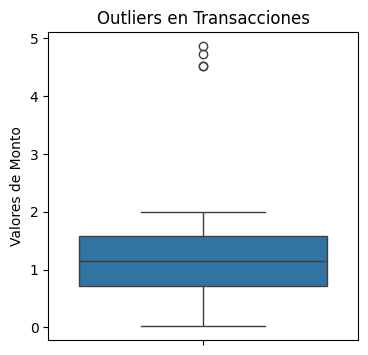

In [13]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='Monto', data=df_criptos)
plt.title('Outliers en Transacciones')
plt.ylabel('Valores de Monto')
plt.show()

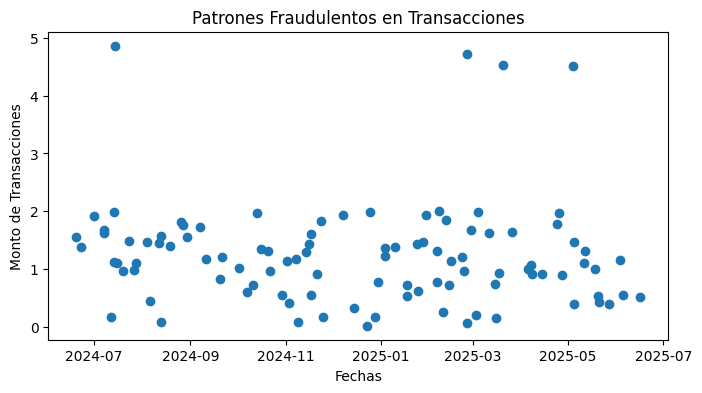

In [14]:
# Caracteristicas de las Transacciones que indican posible Fraude

plt.figure(figsize=(8,4))
plt.scatter(df_criptos["Fecha"], df_criptos["Monto"])
plt.xlabel("Fechas")
plt.ylabel("Monto de Transacciones")
plt.title("Patrones Fraudulentos en Transacciones")

plt.show()

Se observa outliers en los montos de las transacciones, las caracteristicas de patrones fraudulentos en transacciones son diversas, como valores muy elevados o muy bajos en corto tiempo. En este caso, a principios del 2025 se detectan estos patrones. Tambien ayudaria mucho investigar el horario de las transacciones fraudulentas realizadas y el tipo de transaccion (En general son ventas).

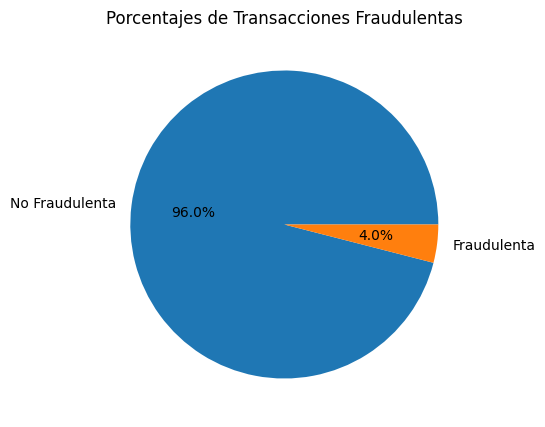

In [15]:
plt.figure(figsize=(5,5))
plt.pie(df_criptos["Fraudulenta o no?"].value_counts(),
        labels=["No Fraudulenta", "Fraudulenta"],
        autopct="%1.1f%%")
plt.title("Porcentajes de Transacciones Fraudulentas")

plt.show()

In [16]:
df_criptos[df_criptos["Fraudulenta o no?"] == 1][[
    "symbol","current_price","price_change_24h","total_volume_billion","Monto","Tipo de transaccion","Fecha"]]

,symbol,current_price,price_change_24h,total_volume_billion,Monto,Tipo de transaccion,Fecha
21,usds,0.999759,-0.000056,0.003088,4.515978,Transferencia,2025-05-04
32,bgb,4.410000,-0.178092,0.040952,4.721904,Venta,2025-02-25
40,tao,348.120000,-40.544046,0.208610,4.522209,Venta,2025-03-20
87,bonk,0.000014,-0.000002,0.253546,4.861682,Compra,2024-07-15


Estos datos de las transacciones fraudulentas permite conocer mas las razones por la cual hubo fraudes. En este caso podemos ver la volatilidad(price_change_24h), el volumen, su tipo de transaccion, etc. Datos claves para la toma de decisiones

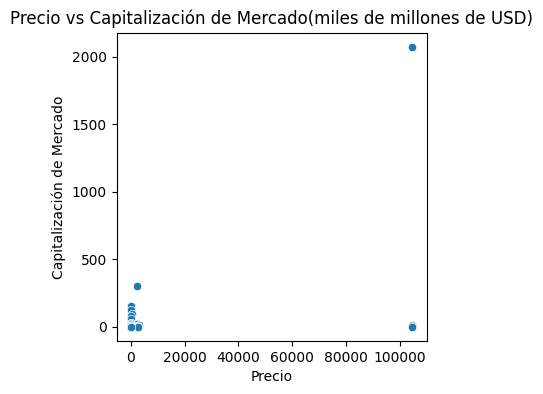

In [17]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='current_price', y='market_cap_billion', data=df_criptos)
plt.title('Precio vs Capitalización de Mercado(miles de millones de USD)')
plt.xlabel('Precio')
plt.ylabel('Capitalización de Mercado')
plt.show()

*  La mayoria de criptomonedas tienen bajo precio y capitalizacion, pero tambien existen criptos con alto precios y baja capitalizacion que indican tokens especulativos y el ultimo caso donde hay altos precios y capitalizacion que indican criptos dominantes en el mercado.

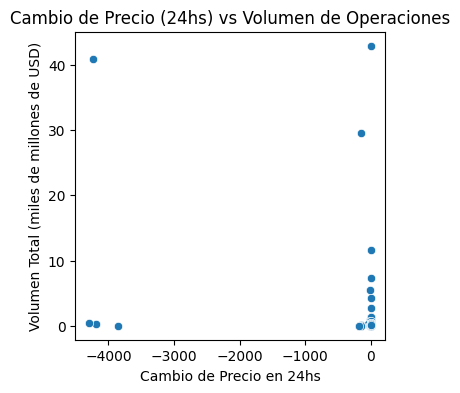

In [18]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='price_change_24h', y='total_volume_billion', data=df_criptos)
plt.title('Cambio de Precio (24hs) vs Volumen de Operaciones')
plt.xlabel('Cambio de Precio en 24hs')
plt.ylabel('Volumen Total (miles de millones de USD)')
plt.show()

*   Alta variación + alto volumen = interés real
*   Alta variación + bajo volumen = manipulación o poca liquidez
*   Bajo cambio + alto volumen = acumulación o estabilidad
*   Ambos bajos = desinterés o estancamiento

Se observa valores bajos en ambas variables, por lo que podemos decir que predomina el desinteres de ciertas criptomonedas

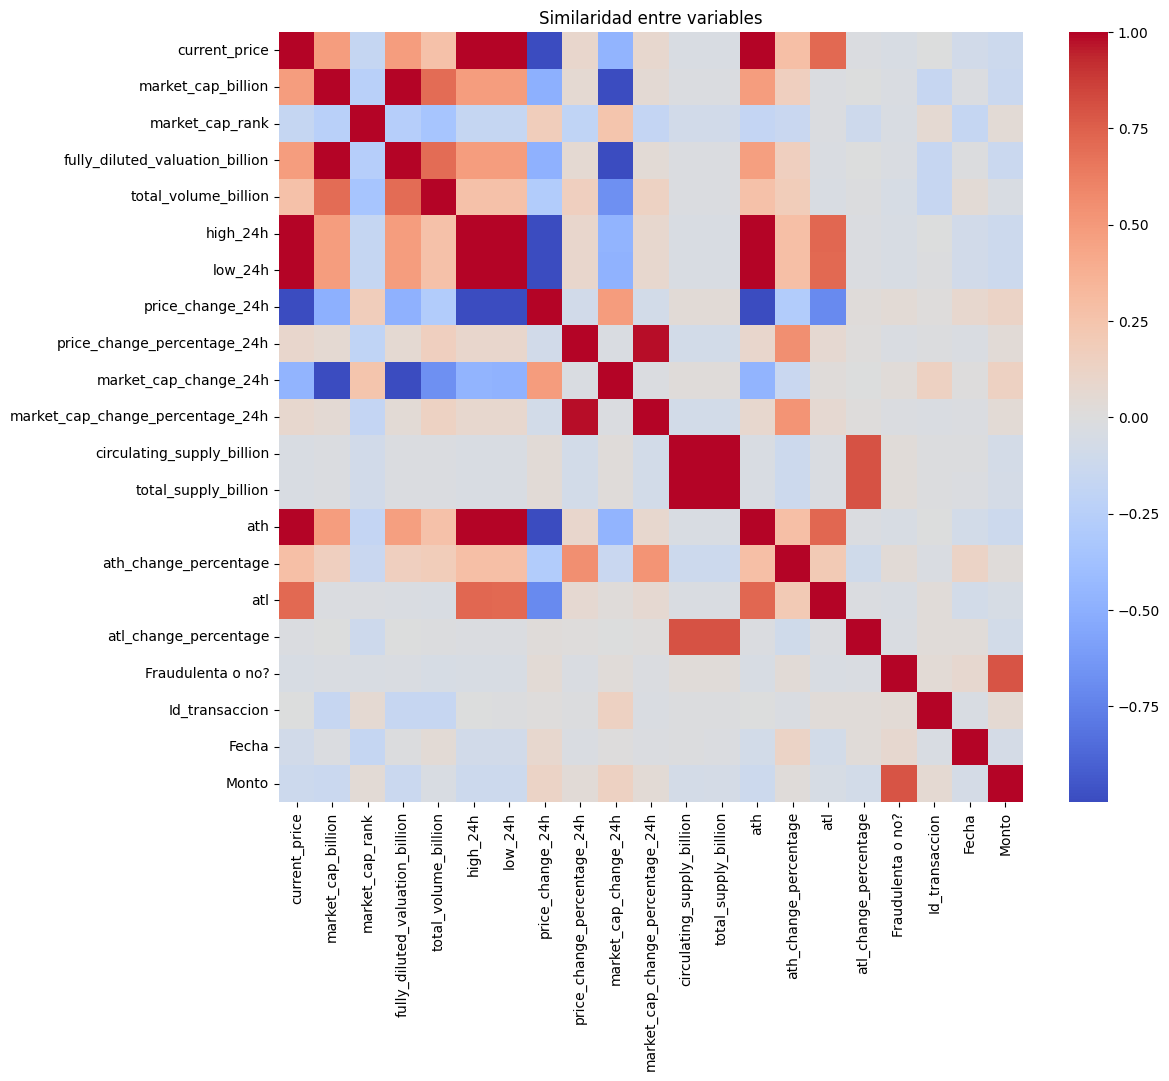

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_criptos.select_dtypes(exclude='object').corr(), annot=False, cmap='coolwarm')
plt.title('Similaridad entre variables')
plt.show()

*   Se observan bastantes similitudes entre variables, pero las mas importantes y que destacan son las que ayudan a encontrar posibles fraudes entre transacciones. Entonces, podemos decir que la mayoria de variables tiene una similitud alta con las demas, por lo que de alguna forma influye en el porque se estafo en esas criptomonedas

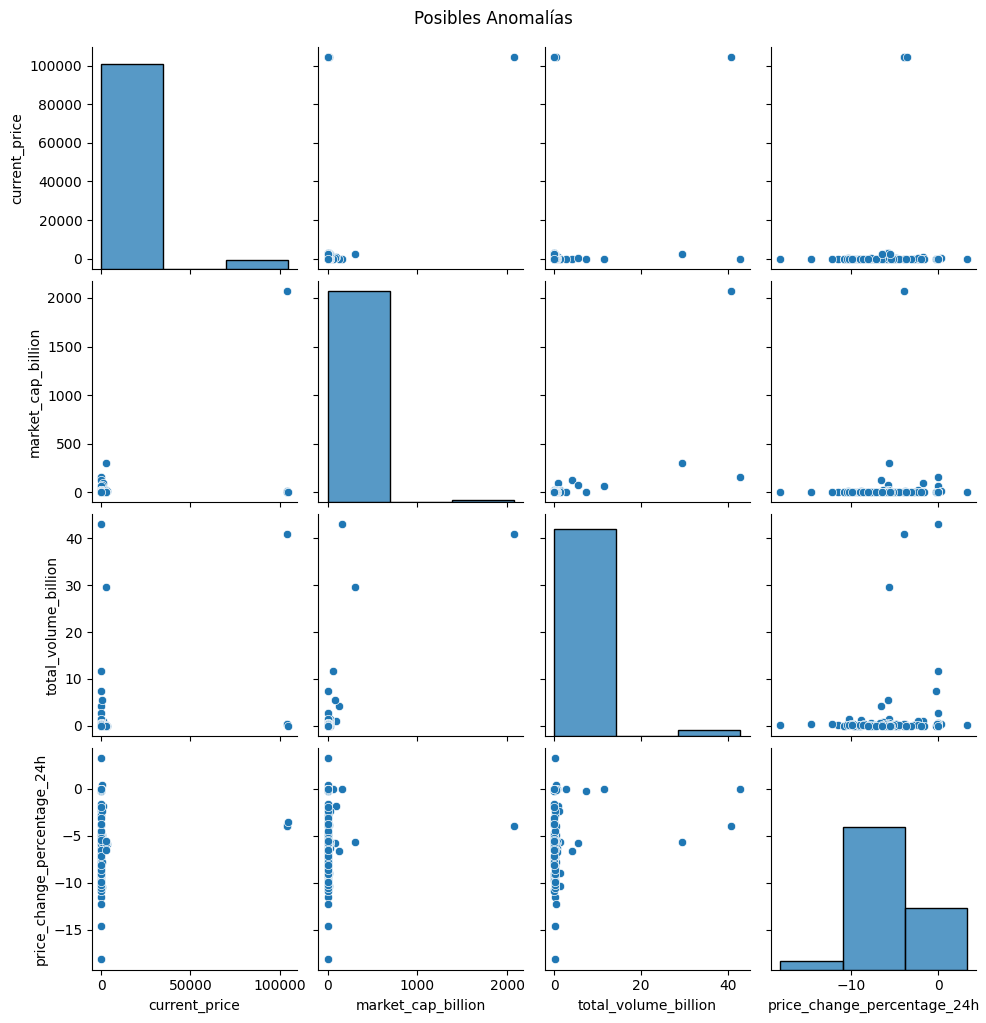

In [20]:
plot = sns.pairplot(df_criptos[[
    'current_price', 'market_cap_billion', 'total_volume_billion', 'price_change_percentage_24h'
]], diag_kind='hist', diag_kws={'bins': 3})

plot.fig.suptitle("Posibles Anomalías", y=1.02)  # No sobreponer el titulo en los graficos
plt.show()

#Modelos

Aclaraciones:

1 = Fraude

0 = No fraude

In [21]:
def kfold(*, modelo, X, y):
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  scores = cross_val_score(modelo, X, y, cv=kf)
  resultado = scores.mean()

  return resultado

In [33]:
class modelos():
  def __init__(self,*, data):
    self.data = data

  def random_forest(self, *, datos_para_predecir):

    # preprocesamiento
    data_copy = self.data.copy()

    data_copy["Fecha"] = pd.to_datetime(data_copy["Fecha"])
    data_copy["Fecha"] = data_copy["Fecha"].dt.day

    X = data_copy[["Monto","Fecha"]]
    y = data_copy["Fraudulenta o no?"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # modelo
    modelo = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    prediccion_prueba = modelo.predict(X_test)
    exactitud_prueba = accuracy_score(y_test, prediccion_prueba)

    datos_para_predecir["Fecha"] = pd.to_datetime(datos_para_predecir["Fecha"])
    datos_para_predecir["Fecha"] = datos_para_predecir["Fecha"].dt.day

    prediccion_original = modelo.predict(datos_para_predecir) # aca pongo la full data a predecir de mi dataset
    exactitud_original = accuracy_score(y, prediccion_original) # "y" seria la full data de los valores reales de mi dataset tambien

    self.data["Predicciones randomforest"] = list(prediccion_original)

    print(self.data[self.data["Predicciones randomforest"] == 1][["symbol","current_price","Fraudulenta o no?","Id_transaccion",
                                                                   "Fecha","Monto","Tipo de transaccion","Predicciones_random_forest"]])
    # gridsearchcv
    params = {"n_estimators": [50, 70, 100, 130], # cant arboles, valor comun = 100
              "max_depth": [None, 5, 10, 15, 20, 25], # profundidad de cada arbol, valor comun = 5-25
              "min_samples_split": [2,3,4,5]} # cant de divisiones aristas de cada nodo

    grid = GridSearchCV(RandomForestClassifier(), params, cv=5) # cv = cross validation
    grid.fit(X_train, y_train)
    mejor_modelo = grid.best_estimator_

    prediccion_mejor_modelo = mejor_modelo.predict(datos_para_predecir)

    self.data["Predicciones lightgbm(gridsearchcv)"] = list(prediccion_mejor_modelo)

    # matriz confusion
    cm = confusion_matrix(y, prediccion_original)
    mostrar_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
    mostrar_cm.plot()

    plt.xlabel("Predicciones")
    plt.ylabel("Valores Reales")
    plt.show()

    # Metricas
    print()
    print(f"\nExactitud de Prueba: {exactitud_prueba}")
    print(f"Exactitud de Prediccion Original: {exactitud_original}")
    print( f"cross_validation(kfold): {kfold(modelo=modelo, X=X, y=y)}\n" )
    print(f"Mejores parametros: {grid.best_params_}")
    print(f"Mejor puntaje(gridsearchcv): {grid.best_score_}")
    print(f"Prediccion_grid_search: {prediccion_mejor_modelo}")

  def xgboost(self, *, features_X):
    data_copy_xgboost = self.data.copy()

    X = features_X
    y = data_copy_xgboost["Fraudulenta o no?"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    modelo = XGBClassifier()
    modelo.fit(X_train, y_train)

    prediccion_prueba = modelo.predict(X_test)
    exactitud = accuracy_score(y_test, prediccion_prueba)

    prediccion_original = modelo.predict(features_X)
    exactitud_original = accuracy_score(y, prediccion_original)

    self.data["Predicciones xgboost"] = list(prediccion_original)
    print(self.data[self.data["Predicciones xgboost"] == 1][["symbol","current_price","Fraudulenta o no?","Id_transaccion",
                                                              "Fecha","Monto","Tipo de transaccion","Predicciones xgboost"]])

    # gridsearchcv
    params = {"n_estimators": [50, 70, 100, 130], # cant arboles, valor comun = 100
              "max_depth": [None, 5, 10, 15, 20, 25], # profundidad de cada arbol, valor comun = 5-25
              "learning_rate": [0.1, 0.001, 0.01], # tasa de aprendizaje del modelo, como en redes neuronales
              "subsample": [0.8, 0.6, 0.7]} # cuantos datos se usan en cada arbol, 80%, 60%...

    grid = GridSearchCV(XGBClassifier(), params, cv=5) # cv = cross validation
    grid.fit(X_train, y_train)
    mejor_modelo = grid.best_estimator_

    prediccion_mejor_modelo = mejor_modelo.predict(features_X)

    self.data["Predicciones xgboost(gridsearchcv)"] = list(prediccion_mejor_modelo)

    # metricas
    print(f"\nExactitud prueba: {exactitud}")
    print(f"Exactitud prediccion original: {exactitud_original}")
    print( f"cross_validation(kfold): {kfold(modelo=modelo, X=X, y=y)}\n" )
    print(f"Mejores parametros: {grid.best_params_}")
    print(f"Mejor puntaje(gridsearchcv): {grid.best_score_}")
    print(f"Prediccion_grid_search: {prediccion_mejor_modelo}")

  def lightgbm(self):
    data_copy_lightgbm = self.data.copy()

    #modelo
    X = data_copy_lightgbm[["price_change_24h","market_cap_change_24h", "Monto", "current_price"]]
    y = data_copy_lightgbm["Fraudulenta o no?"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    modelo = LGBMClassifier(verbose=-1)
    modelo.fit(X_train, y_train)

    prediccion_prueba = modelo.predict(X_test)
    exactitud_prueba = accuracy_score(y_test, prediccion_prueba)

    prediccion_original = modelo.predict(X)
    exactitud_original = accuracy_score(y, prediccion_original)

    self.data["Predicciones lightgbm"] = list(prediccion_original)
    print(self.data[self.data["Predicciones lightgbm"] == 1][["symbol","current_price","Fraudulenta o no?","Id_transaccion",
                                                              "Fecha","Monto","Tipo de transaccion", "Predicciones lightgbm"]])
    # gridsearchcv
    params = {"n_estimators": [75,100,125],
            "max_depth": [5,10,15,20,25],
            "learning_rate": [0.001, 0.01, 0.1],
            "num_leaves": [25,30,35,40]}

    grid = GridSearchCV(LGBMClassifier(), params, cv=5) # cv = cross validation
    grid.fit(X_train, y_train)

    mejor_modelo = grid.best_estimator_
    prediccion_mejor_modelo = mejor_modelo.predict(X)

    self.data["Predicciones lightgbm(gridsearchcv)"] = list(prediccion_mejor_modelo)

    # metricas
    print("\nexactitud_prueba: ",exactitud_prueba)
    print(f"exactitud_original: {exactitud_original}")
    print( f"cross_validation(kfold): {kfold(modelo=modelo, X=X, y=y)}\n" )
    print(f"Mejores parametros: {grid.best_params_}")
    print(f"Mejor puntaje(gridsearchcv): {grid.best_score_}")
    print(f"Prediccion_grid_search: {prediccion_mejor_modelo}")

modelos = modelos(data=df_criptos)

   symbol  current_price  Fraudulenta o no?  Id_transaccion      Fecha  \
21   usds       0.999759                  1            6145 2025-05-04   
32    bgb       4.410000                  1            8493 2025-02-25   
40    tao     348.120000                  1            2485 2025-03-20   
87   bonk       0.000014                  1            6788 2024-07-15   

       Monto Tipo de transaccion  Predicciones_random_forest  
21  4.515978       Transferencia                           1  
32  4.721904               Venta                           1  
40  4.522209               Venta                           1  
87  4.861682              Compra                           1  


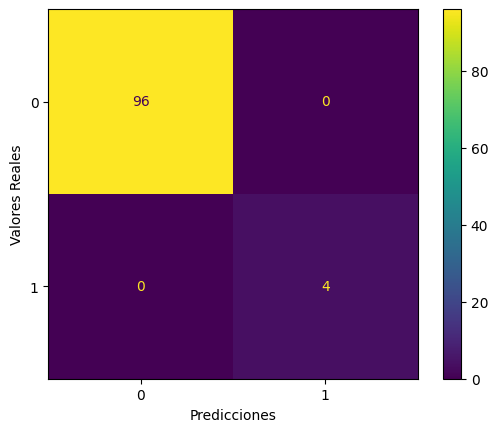



Exactitud de Prueba: 1.0
Exactitud de Prediccion Original: 1.0
cross_validation(kfold): 0.9800000000000001

Mejores parametros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Mejor puntaje(gridsearchcv): 1.0
Prediccion_grid_search: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [34]:
full_data_predecir = df_criptos[["Monto", "Fecha"]]
modelos.random_forest(datos_para_predecir = full_data_predecir)

In [35]:
datos_features_X = pd.get_dummies(df_criptos, columns=["Tipo de transaccion"])
datos_features_X.iloc[:, -3:] = datos_features_X.iloc[:, -3:].astype(int)
datos_features_X = datos_features_X[["Monto","Tipo de transaccion_Compra", "Tipo de transaccion_Transferencia", "Tipo de transaccion_Venta",
                                     "price_change_24h", "market_cap_change_24h", "total_volume_billion"]]

modelos.xgboost(features_X = datos_features_X)

   symbol  current_price  Fraudulenta o no?  Id_transaccion      Fecha  \
21   usds       0.999759                  1            6145 2025-05-04   
32    bgb       4.410000                  1            8493 2025-02-25   
40    tao     348.120000                  1            2485 2025-03-20   
87   bonk       0.000014                  1            6788 2024-07-15   
98   meth    2654.050000                  0            3832 2025-02-07   

       Monto Tipo de transaccion  Predicciones xgboost  
21  4.515978       Transferencia                     1  
32  4.721904               Venta                     1  
40  4.522209               Venta                     1  
87  4.861682              Compra                     1  
98  1.999538              Compra                     1  
Exactitud prueba: 1.0
Exactitud prediccion original: 0.99
cross_validation(kfold): 0.95
Mejores parametros: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 50, 'subsample': 0.8}
Mejor puntaje(gridsearchc

In [36]:
modelos.lightgbm()

   symbol  current_price  Fraudulenta o no?  Id_transaccion      Fecha  \
21   usds       0.999759                  1            6145 2025-05-04   
32    bgb       4.410000                  1            8493 2025-02-25   
40    tao     348.120000                  1            2485 2025-03-20   
87   bonk       0.000014                  1            6788 2024-07-15   

       Monto Tipo de transaccion  Predicciones lightgbm  
21  4.515978       Transferencia                      1  
32  4.721904               Venta                      1  
40  4.522209               Venta                      1  
87  4.861682              Compra                      1  

exactitud_prueba:  1.0
exactitud_original: 1.0
cross_validation(kfold): 0.99

Mejores parametros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'num_leaves': 25}
Mejor puntaje(gridsearchcv): 0.975
Prediccion_grid_search: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 

#Conclusiones Finales

##Insights

*   Las criptomonedas fraudulentas son wsteth, wbt, okb, ip. Y constituyen un 4% de transacciones fraudulentas
*   Porque razones se estafo con esas Criptomonedas?: Generalmente cuando un año nuevo arranca, hay mas novatos metiendose en el mundo del blockchain, tambien por eventos significativos como "La moneda del presidente Milei que resulto una estafa"
*   2 transacciones fraudulentas son ventas, otra es transaccion y la ultima es compra. Generalmente el tipo de transaccion en estos casos, son ventas, ya que se busca estafar con precios altos
*  Los fraudes en este caso, tienen precios muy elevados y anormales, tambien podrian haber sido precios muy bajos.
*  Existen pocos casos de criptomonedas con tokens especulativos(alta volatilidad y riesgo) que su valor depende solamente de la demanda en tiempo real

## Insights finales

*   se descubre un quinto fraude con el modelo xgboost, la moneda digital "meth" con un precio actual de "2654.05" pero con un monto de transaccion de "1.99". Aca se evaluan mas variables que influyen en la transaccion
*   Los fraudes se situan en la primera mitad del anio 2025, no se observan fraudes en fechas especiales ni cerca del fin de anio
*   Por ahora, las ventas y compras son las mas comunes donde aparecen fraudes. Transacciones echas por transferencia solo hay una
*   El promedio del monto de las transacciones fraudulentas es de: 4.12
*   Las etiquetas fraudulentas terminaron ser verdaderas gracias a los modelos implementados



##Sugerencia final:

Poner mas atencion en la primera mitad del anio, monedas digitales como  usds, bgb, tao, bonk y meth deberian de ser suspendidas por un tiempo debido que existen fraudes en ellas. Buscar otras monedas para transacciones por un tiempo. Analizar constantemente esas monedas fraudulentas hasta notar mejorias. Usar mas datos para comprobar que son 100% fraudulentas o hallar mas transacciones fraudulentas. Seguir usando estos modelos de machine learning e implementar mas adelantes redes neuronales

##Con respecto a la hipotesis(final):

Los eventos significativos a principios del 2025 como "$Libra de Milei" influyeron en los fraudes de las criptomonedas, porque lo que, la hipotesis cumplio ciertamente con su proposito. Tambien influyen otras y muchas variables pero una de las principales es esa.

Las fechas que se registraron donde ocurrio los fraudes, no se observan dias especiales en argentina, excepto el evento de milei. pero probablemente en otros paises hayan dias especial, se deberia de hacer una investigacion profunda sobre ese tema